In [1]:
import os

from openpyxl.styles.builtins import output
from tensorboard.plugins.graph.keras_util import keras_model_to_graph_def
from webcolors import names

os.environ['KERAS_BACKEND'] = 'tensorflow'

from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-05-07 14:34:16.562082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 14:34:16.609866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746624856.638070   85191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746624856.645433   85191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746624856.690171   85191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [3]:
target_size = 32
representation_dims = 512
projection_unites = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [4]:
data_processing = keras.Sequential([
    layers.Resizing(target_size, target_size),
    layers.Normalization()
])

data_processing.layers[-1].adapt(x_data)

I0000 00:00:1746624861.704168   85191 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(
        height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'
    ),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.15, fill_mode='nearest'),
    layers.RandomZoom(
        height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode='nearest'
    ),
])

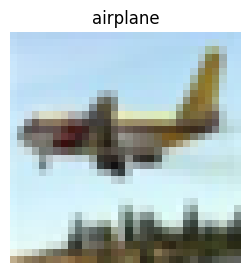

In [6]:
image_index = np.random.choice(range(x_data.shape[0]))
image = x_data[image_index]
image_class = classes[y_data[image_index][0]]
plt.figure(figsize=(3,3))
plt.imshow(x_data[image_index].astype('uint8'))
plt.title(image_class)
_ = plt.axis('off')

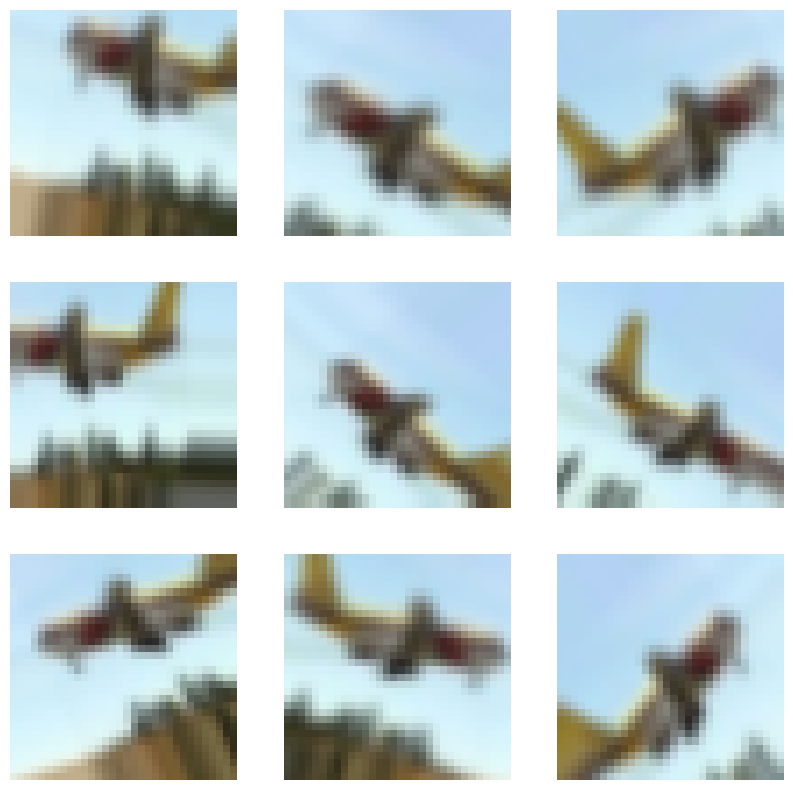

In [7]:
plt.figure(figsize=(10,10))

for i in range(9):
    augmented_image = data_augmentation(np.array([image]))
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [8]:
def create_encoder(representation_dims):
    encoder = keras.Sequential([
        keras.applications.ResNet50V2(
            include_top=False,
            weights=None,
            pooling='avg',
        ),
        layers.Dense(representation_dims)
    ])

    return encoder

In [9]:
class RepresentationLearner(keras.Model):
    def __init__(self, encoder, projection_unites, num_augmentations, temperature=1.0, dropout_rate=0.1, i2_normalize=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder

        self.projector = keras.Sequential([
            layers.Dropout(dropout_rate),
            layers.Dense(units=projection_unites, use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.i2_normalize = i2_normalize
        self.loss_tracker = keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vector, batch_size):
        num_augmentations = keras.ops.shape(feature_vector)[0] // batch_size
        if self.i2_normalize:
            feature_vector = keras.utils.normalize(feature_vector)

        logits = (
            tf.linalg.matmul(feature_vector, feature_vector, transpose_b=True) / self.temperature
        )

        logits_max = keras.ops.max(logits, axis=1)
        logits = logits - logits_max

        targets = keras.ops.tile(
            tf.eye(batch_size), [num_augmentations, num_augmentations],
        )

        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        preprocessed = data_processing(inputs)
        augmented = []

        for _ in range(self.num_augmentations):
            augmented_img = data_augmentation(preprocessed)
            augmented.append(self.encoder(augmented_img))

        features = layers.Concatenate(axis=0)(augmented)
        return self.projector(features)


    def train_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]

        with tf.GradientTape() as tape:
            features_vector = self(inputs, training=True)
            loss = self.compute_contrastive_loss(features_vector, batch_size)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        features_vector = self(inputs, training=False)
        loss = self.compute_contrastive_loss(features_vector, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [10]:
encoder = create_encoder(representation_dims)
representation_learner = RepresentationLearner(
    encoder, projection_unites, num_augmentations=2, temperature=0.1)


lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    alpha=0.1
)

representation_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler,
                                     weight_decay=0.0001,),
    jit_compile=False,
)

history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)


Epoch 1/50


I0000 00:00:1746624888.565299   85312 cuda_dnn.cc:529] Loaded cuDNN version 90300


118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 331ms/step - loss: 7.2873
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - loss: 4.4118
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - loss: 3.6716
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - loss: 3.3773
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - loss: 3.2418
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 289ms/step - loss: 3.1739
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - loss: 3.1293
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - loss: 3.0777
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - loss: 3.0238
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 300ms/step - loss: 2.9789
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step - loss: 2.9332
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 304ms/step - loss: 2.8980
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - loss: 2.8572
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 302ms/step - loss: 2.8263
Epoch 15/50
118/118 ━━━━━━

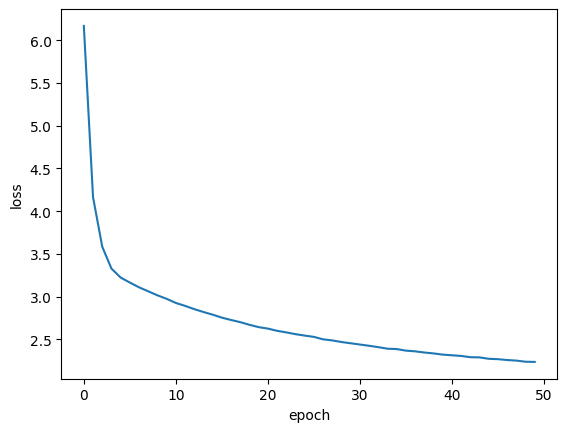

In [11]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [17]:
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = keras.utils.normalize(feature_vectors)

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [18]:
feature_vectors

array([[ 1.07560322e-01,  2.22722092e-03, -2.85651516e-02, ...,
         7.15370923e-02,  2.60384921e-02, -1.55516155e-03],
       [ 1.07128695e-01, -7.29649037e-04, -2.78381463e-02, ...,
         7.17000440e-02,  3.12703103e-02, -1.42831728e-03],
       [ 1.08444348e-01, -2.23913114e-03, -2.78480519e-02, ...,
         7.26170763e-02,  3.29442769e-02, -7.99191941e-04],
       ...,
       [ 1.07251085e-01,  2.28444207e-03, -2.80910451e-02, ...,
         7.12724328e-02,  2.80857272e-02, -1.07509177e-03],
       [ 1.08531654e-01,  3.87025320e-05, -2.84488183e-02, ...,
         7.17530027e-02,  2.97581889e-02, -8.77695100e-04],
       [ 1.08462200e-01,  2.94455094e-04, -2.84408927e-02, ...,
         7.15022311e-02,  3.22571695e-02, -1.29192078e-03]], dtype=float32)

In [20]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = keras.ops.top_k(similarities, k=kn + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, kn))

100%|██████████| 120/120 [00:04<00:00, 26.25it/s]


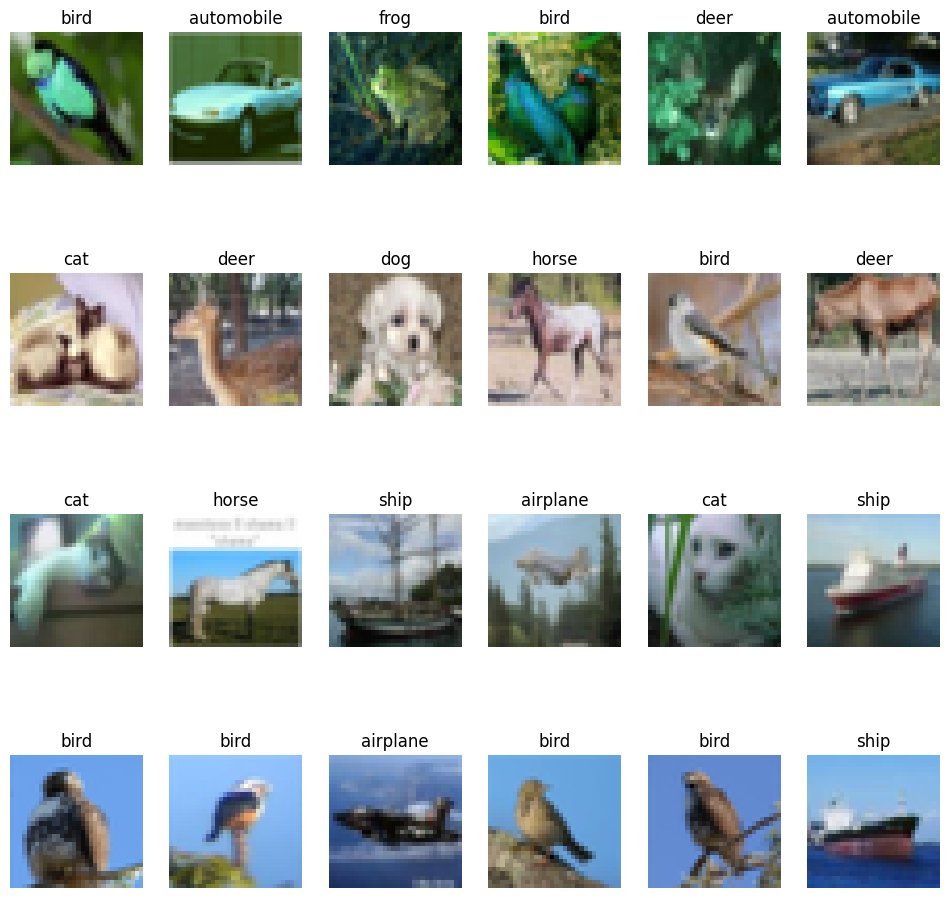

In [22]:
nrows = 4
ncols = kn + 1

plt.figure(figsize=(12, 12))
positions = 1

for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indices = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indices.tolist()

    for j in range(ncols):
        plt.subplot(nrows, ncols, positions)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis('off')
        positions += 1



In [23]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        target = keras.ops.ones_like(similarity)

        loss = keras.losses.binary_crossentropy(
            y_true=target,
            y_pred=similarity,
            from_logits=True
        )

        return keras.ops.mean(loss)

In [38]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probablities, similarity, sample_weight=None):
        num_clusters = keras.ops.cast(
            keras.ops.shape(cluster_probablities)[-1], 'float32'
        )

        target = keras.ops.log(num_clusters)
        cluster_probablities = keras.ops.mean(cluster_probablities, axis=0)
        cluster_probablities = keras.ops.clip(cluster_probablities, 1e-8, 1.0)

        entropy = -keras.ops.sum(
            cluster_probablities * keras.ops.log(cluster_probablities),
        )
        loss = target - entropy

        return loss

In [29]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    preprocessed = data_processing(inputs)
    augmented = data_augmentation(preprocessed)
    features = encoder(augmented)
    outputs = layers.Dense(units=num_clusters, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [34]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name='anchor')
    neighbours = keras.Input(shape=tuple([kn]) + input_shape, name='neighbours')

    neighbours_reshaped = keras.ops.reshape(neighbours, tuple([-1]) + input_shape)

    anchor_clustering = clustering_model(anchor)
    neighbour_clustering = clustering_model(neighbours_reshaped)
    neighbour_clustering = keras.ops.reshape(
        neighbour_clustering,
        (-1, kn, keras.ops.shape(neighbour_clustering)[-1])
    )

    simlarity = keras.ops.einsum(
        "bij,bkj->bik",
        keras.ops.expand_dims(anchor_clustering, axis=1),
        neighbour_clustering,
    )

    simlarity = layers.Lambda(
        lambda x: keras.ops.squeeze(x, axis=1), name='simlarity'
    ) (simlarity)

    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[simlarity, anchor_clustering],
        name='clustering_learner'
    )

    return model

In [39]:
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

clustering_model = create_clustering_model(encoder, num_clusters, name='clustering')
clustering_learner = create_clustering_learner(clustering_model)

losses = [ClustersEntropyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

inputs = {"anchor": x_data, 'neighbours': tf.gather(x_data, neighbours)}
labels = [np.ones(shape=(x_data.shape[0], kn)), np.ones(shape=(x_data.shape[0], kn))]

clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

clustering_learner.fit(
    x=inputs,
    y=labels,
    batch_size=512,
    epochs=50
)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - clustering_loss: 0.0305 - loss: 0.3530 - simlarity_loss: 0.3225
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - clustering_loss: 0.0247 - loss: -0.1711 - simlarity_loss: -0.1958
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - clustering_loss: 0.0188 - loss: -0.1973 - simlarity_loss: -0.2162
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - clustering_loss: 0.0183 - loss: -0.2044 - simlarity_loss: -0.2226
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - clustering_loss: 0.0192 - loss: -0.2059 - simlarity_loss: -0.2250
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - clustering_loss: 0.0189 - loss: -0.2071 - simlarity_loss: -0.2260
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - clustering_loss: 0.0186 - loss: -0.2074 - simlarity_loss: -0.2260
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - clustering_loss: 0.0189 - loss: -0.2073 - simlarity_loss: -0.2262
Epoch 9/50
118/118

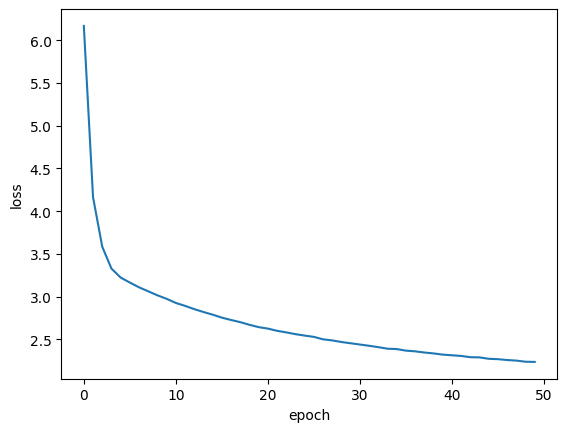

In [40]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [45]:
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
clustering_assigments = keras.ops.argmax(clustering_probs, axis=-1).numpy()

clustering_confidence = keras.ops.max(clustering_probs, axis=-1).numpy()

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [46]:
import pandas as pd
pd.DataFrame(clustering_assigments)

,0
0,0
1,10
2,4
3,0
4,21
...,...
59995,24
59996,9
59997,16
59998,4


In [44]:
pd.DataFrame(clustering_confidence)

,0
0,0.917033
1,0.696029
2,0.480623
3,0.690976
4,0.909442
...,...
59995,0.993138
59996,0.597056
59997,0.807247
59998,0.557642


In [47]:
clusters = defaultdict(list)
for idx, c in enumerate(clustering_assigments):
    clusters[c].append((idx, clustering_confidence[idx]))

non_empty_clusters = defaultdict(list)

for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print('cluster',c,':', len(clusters[c]))


cluster 0 : 1867
cluster 1 : 2163
cluster 2 : 2068
cluster 3 : 1676
cluster 4 : 1864
cluster 5 : 1791
cluster 6 : 1801
cluster 7 : 2029
cluster 8 : 1992
cluster 9 : 2971
cluster 10 : 2585
cluster 11 : 2071
cluster 12 : 2399
cluster 13 : 1607
cluster 14 : 2422
cluster 15 : 2149
cluster 16 : 1774
cluster 17 : 1997
cluster 18 : 2125
cluster 19 : 2461
cluster 20 : 2014
cluster 21 : 2567
cluster 22 : 2000
cluster 23 : 2135
cluster 24 : 2477
cluster 25 : 2389
cluster 26 : 2061
cluster 27 : 2545


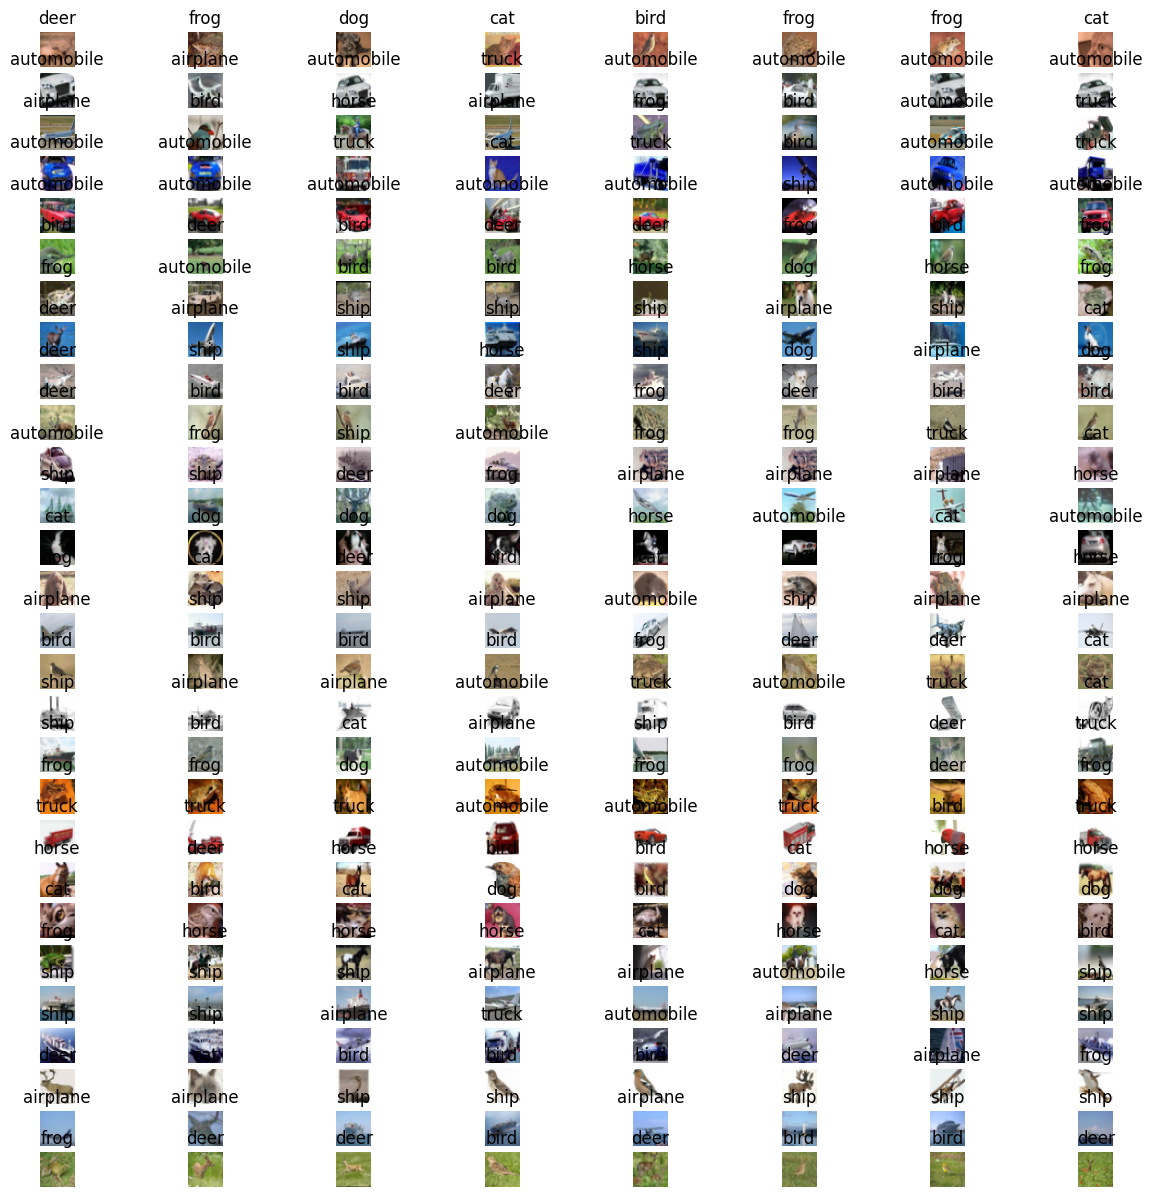

In [49]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in non_empty_clusters.keys():
    cluster_instances = sorted(
        non_empty_clusters[c], key=lambda kv: kv[1], reverse=True
    )

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(len(non_empty_clusters), num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1




In [54]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]


    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1


    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])

    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )

    cluster_label = classes[cluster_label_idx]

    print('cluster ', c, 'label is: ', cluster_label, ' - accuracy: ', accuracy, '%')

cluster  0 label is:  frog  - accuracy:  34.82 %
cluster  1 label is:  bird  - accuracy:  13.22 %
cluster  2 label is:  cat  - accuracy:  19.58 %
cluster  3 label is:  cat  - accuracy:  21.36 %
cluster  4 label is:  bird  - accuracy:  15.5 %
cluster  5 label is:  airplane  - accuracy:  26.24 %
cluster  6 label is:  frog  - accuracy:  31.98 %
cluster  7 label is:  deer  - accuracy:  32.28 %
cluster  8 label is:  ship  - accuracy:  28.41 %
cluster  9 label is:  horse  - accuracy:  27.6 %
cluster  10 label is:  automobile  - accuracy:  32.96 %
cluster  11 label is:  airplane  - accuracy:  26.17 %
cluster  12 label is:  frog  - accuracy:  27.89 %
cluster  13 label is:  airplane  - accuracy:  49.04 %
cluster  14 label is:  airplane  - accuracy:  32.25 %
cluster  15 label is:  deer  - accuracy:  22.89 %
cluster  16 label is:  dog  - accuracy:  28.58 %
cluster  17 label is:  horse  - accuracy:  21.53 %
cluster  18 label is:  truck  - accuracy:  24.42 %
cluster  19 label is:  dog  - accuracy: 